In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
'''

Use this cell for planning out approach, notes of what has worked/what doesn't work, status of code for next time, etc


The goal of this is to measure the density of vacancies created at different depths within the sample. This will then also bleed 
into measuring the track width at different depths of the sample - that will be a part 2 most likely and will build off of 
studying the vacancies.

What do we need to know in order to find new vacanies and compare it to the original value - well, 0?

    - the crystal spacing of the material being studied
    - if I can export out the particles that are highlighted in OVITO for being kicked out of their original spacing
    
    
Things to take into account:
    - need to delete the outermost particles since they are naturally considered out of the original position because of 
    how LAMMPS/OVITO works 
    - finding the 1 sigma confidence interval on said measurements
    - compare these against the data we have (note I need to seriously kick up the energy of the inbound ion before I 
    can get to this point)


Steps to accomplish to get this working:
    - load in data and ensure it is visible/makes sense
    - delete outside atoms so they don't impact statistics
    - find a way to quantify the number of vacancies there are at one timestep
    - find the vacancy density at a region
    - find the +- 1 sigma confidence interval on these measurements
    - make a plot for varying track depths tracking the vacancy density at that particular region
    - find the track length and width vs depth into sample
    - ensure that there aren't discrepancies between track length calculations and vacancy density calculations


'''

### Step 1: Get Data Loaded and Visualized

In [32]:
data1 = pd.read_csv('newtest', sep = " ")
data2 = pd.read_csv('thermal_layer_vers', sep = " ")
data3 = pd.read_csv('10kev_21pico_ters', sep = " ")
data4 = pd.read_csv('20kev_27pico_ters', sep = " ")

data1['x'], data2['x'], data3['x'], data4['x'], = data1['x'].values / 10, data2['x'].values / 10, data3['x'].values / 10, data4['x'].values / 10
data1['y'], data2['y'], data3['y'], data4['y'], = data1['y'].values / 10, data2['y'].values / 10, data3['y'].values / 10, data4['y'].values / 10
data1['z'], data2['z'], data3['z'], data4['z'], = data1['z'].values / 10, data2['z'].values / 10, data3['z'].values / 10, data4['z'].values / 10

data4

,id,type,x,y,z,coordination,step
0,51366,1,0.166585,-2.153460,-1.265880,3,29000.0
1,168764,2,-3.856010,11.394900,-0.396562,3,29000.0
2,170543,1,-2.846630,11.323500,-1.013580,3,29000.0
3,170727,2,-2.607320,11.352600,10.816500,3,29000.0
4,171425,1,-2.238770,11.313400,-1.591570,3,29000.0
...,...,...,...,...,...,...,...
2275,1268129,1,1.252560,-0.530654,1.093230,3,29000.0
2276,1268130,1,0.911680,-0.288679,1.435650,3,29000.0
2277,1268161,1,2.204650,-0.506441,2.040910,2,29000.0
2278,1268167,1,0.825148,0.143464,1.903260,5,29000.0


In [33]:
steps1, steps2, steps3= np.unique(data1['step'].values), np.unique(data2['step'].values), np.unique(data3['step'].values)
steps4 = np.unique(data4['step'].values)

data_1 = data1[data1['step'] == steps1[0]].copy()
data_1 = data_1.sort_values(by = 'id')
data_2 = data2[data2['step'] == steps2[0]].copy()
data_2 = data_2.sort_values(by = 'id')
data_3 = data3[data3['step'] == steps3[0]].copy()
data_3 = data_3.sort_values(by = 'id')
data_4 = data4[data4['step'] == steps4[0]].copy()
data_4 = data_4.sort_values(by = 'id')
data_2

,id,type,x,y,z,coordination,step
0,48222,1,9.91389,-1.875740,1.635250,3,18000.0
1,48493,1,9.30835,-1.176730,-0.251697,3,18000.0
2,48494,1,9.53779,-1.202950,-0.437308,3,18000.0
3,48502,1,9.19941,-1.152980,0.316817,3,18000.0
4,48510,1,9.63139,-1.419120,0.513759,3,18000.0
...,...,...,...,...,...,...,...
361,342202,2,5.66206,-0.521016,-1.425500,1,18000.0
362,342380,1,4.85952,0.099097,-0.961949,3,18000.0
363,342550,1,4.35003,0.566561,-0.163163,3,18000.0
364,342551,1,4.46327,0.418624,-0.590055,3,18000.0


(-6.10934, 10.8777)

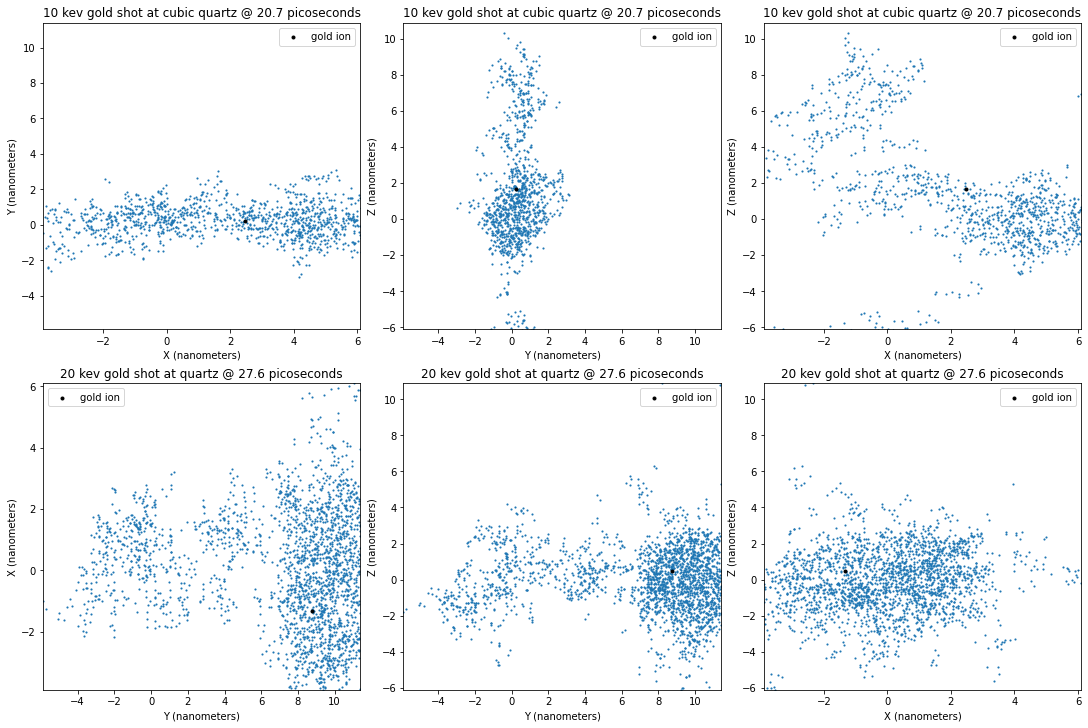

In [39]:
x_min = min(data_4['x'].min(), data_4['x'].min())
x_max = max(data_4['x'].max(), data_4['x'].max())
y_min = min(data_4['y'].min(), data_4['y'].min())
y_max = max(data_4['y'].max(), data_4['y'].max())
z_min = min(data_4['z'].min(), data_4['z'].min())
z_max = max(data_4['z'].max(), data_4['z'].max())

######################################################################################

fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

#axes[0,0].scatter(data_1['x'].values, data_1['y'].values, s = 5, marker = '.')
#axes[0,0].scatter(data_1[data_1['type'] == 3]['x'].values, data_1[data_1['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,0].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,0].set_xlabel('X (nanometers)')
#axes[0,0].set_ylabel('Y (nanometers)')
#axes[0,0].legend(loc = 'best')
#axes[0,0].set_xlim(x_min, x_max)
#axes[0,0].set_ylim(y_min, y_max)

#axes[0,1].scatter(data_1['y'].values, data_1['z'].values, s = 5, marker = '.')
#axes[0,1].scatter(data_1[data_1['type'] == 3]['y'].values, data_1[data_1['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,1].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,1].set_xlabel('Y (nanometers)')
#axes[0,1].set_ylabel('Z (nanometers)')
#axes[0,1].legend(loc = 'best')
#axes[0,1].set_xlim(y_min, y_max)
#axes[0,1].set_ylim(z_min, z_max)

#axes[0,2].scatter(data_1['x'].values, data_1['z'].values, s = 5, marker = '.')
#axes[0,2].scatter(data_1[data_1['type'] == 3]['x'].values, data_1[data_1['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[0,2].set_title('gold shot at quartz - no thermal at 60 picoseconds')
#axes[0,2].set_xlabel('X (nanometers)')
#axes[0,2].set_ylabel('Z (nanometers)')
#axes[0,2].legend(loc = 'best')
#axes[0,2].set_xlim(x_min, x_max)
#axes[0,2].set_ylim(z_min, z_max)

######################################################################################

axes[0,0].scatter(data_3['x'].values, data_3['y'].values, s = 5, marker = '.')
axes[0,0].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,0].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,0].set_xlabel('X (nanometers)')
axes[0,0].set_ylabel('Y (nanometers)')
axes[0,0].legend(loc = 'best')
axes[0,0].set_xlim(x_min, x_max)
axes[0,0].set_ylim(y_min, y_max)

axes[0,1].scatter(data_3['y'].values, data_3['z'].values, s = 5, marker = '.')
axes[0,1].scatter(data_3[data_3['type'] == 3]['y'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,1].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,1].set_xlabel('Y (nanometers)')
axes[0,1].set_ylabel('Z (nanometers)')
axes[0,1].legend(loc = 'best')
axes[0,1].set_xlim(y_min, y_max)
axes[0,1].set_ylim(z_min, z_max)

axes[0,2].scatter(data_3['x'].values, data_3['z'].values, s = 5, marker = '.')
axes[0,2].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[0,2].set_title('10 kev gold shot at cubic quartz @ 20.7 picoseconds')
axes[0,2].set_xlabel('X (nanometers)')
axes[0,2].set_ylabel('Z (nanometers)')
axes[0,2].legend(loc = 'best')
axes[0,2].set_xlim(x_min, x_max)
axes[0,2].set_ylim(z_min, z_max)

######################################################################################

axes[1,0].scatter(data_4['y'].values, data_4['x'].values, s = 5, marker = '.')
axes[1,0].scatter(data_4[data_4['type'] == 3]['y'].values, data_4[data_4['type'] == 3]['x'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,0].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,0].set_xlabel('Y (nanometers)')
axes[1,0].set_ylabel('X (nanometers)')
axes[1,0].legend(loc = 'best')
axes[1,0].set_xlim(y_min, y_max)
axes[1,0].set_ylim(x_min, x_max)

axes[1,1].scatter(data_4['y'].values, data_4['z'].values, s = 5, marker = '.')
axes[1,1].scatter(data_4[data_4['type'] == 3]['y'].values, data_4[data_4['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,1].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,1].set_xlabel('Y (nanometers)')
axes[1,1].set_ylabel('Z (nanometers)')
axes[1,1].legend(loc = 'best')
axes[1,1].set_xlim(y_min, y_max)
axes[1,1].set_ylim(z_min, z_max)

axes[1,2].scatter(data_4['x'].values, data_4['z'].values, s = 5, marker = '.')
axes[1,2].scatter(data_4[data_4['type'] == 3]['x'].values, data_4[data_4['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
axes[1,2].set_title('20 kev gold shot at quartz @ 27.6 picoseconds')
axes[1,2].set_xlabel('X (nanometers)')
axes[1,2].set_ylabel('Z (nanometers)')
axes[1,2].legend(loc = 'best')
axes[1,2].set_xlim(x_min, x_max)
axes[1,2].set_ylim(z_min, z_max)

######################################################################################

#axes[2,0].scatter(data_3['x'].values, data_3['y'].values, s = 5, marker = '.')
#axes[2,0].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['y'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,0].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,0].set_xlabel('X (angstroms)')
#axes[2,0].set_ylabel('Y (angstroms)')
#axes[2,0].legend(loc = 'best')
#axes[2,0].set_xlim(x_min, x_max)
#axes[2,0].set_ylim(y_min, y_max)

#axes[2,1].scatter(data_3['y'].values, data_3['z'].values, s = 5, marker = '.')
#axes[2,1].scatter(data_3[data_3['type'] == 3]['y'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,1].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,1].set_xlabel('Y (angstroms)')
#axes[2,1].set_ylabel('Z (angstroms)')
#axes[2,1].legend(loc = 'best')
#axes[2,1].set_xlim(y_min, y_max)
#axes[2,1].set_ylim(z_min, z_max)

#axes[2,2].scatter(data_3['x'].values, data_3['z'].values, s = 5, marker = '.')
#axes[2,2].scatter(data_3[data_3['type'] == 3]['x'].values, data_3[data_3['type'] == 3]['z'].values, color = 'black', marker = '.', label = 'gold ion')
#axes[2,2].set_title('gold shot at quartz - with thermal & fixed at 33 picoseconds')
#axes[2,2].set_xlabel('X (angstroms)')
#axes[2,2].set_ylabel('Z (angstroms)')
#axes[2,2].legend(loc = 'best')
#axes[2,2].set_xlim(x_min, x_max)
#axes[2,2].set_ylim(z_min, z_max)

### Step 3: Try to quantify number of vacancies

In [43]:
num_vacancies1 = [len(data_1[data_1['step'] == step]) for step in steps1]
num_vacancies2 = [len(data_2[data_2['step'] == step]) for step in steps2]
num_vacancies3 = [len(data_3[data_3['step'] == step]) for step in steps3]
num_vacancies4 = [len(data_4[data_4['step'] == step]) for step in steps4]

'''
it might just be this easy since once we get into the the core of the sample a vacancy arises when a particle is knocked out
there must be a vacancy left behind, but triple check with Emilie to make sure this is correct - otherwise modify 
'''
num_vacancies1
num_vacancies2
num_vacancies3
num_vacancies4

ratio = num_vacancies4[0] / num_vacancies3[0]
ratio
print(f"at 20.7 picoseconds for the 10 keV gold ion there were {num_vacancies3[0]} vacancies")
print(f"at 27.6 picoseconds for the 20 keV gold ion there were {num_vacancies4[0]} vacancies")

at 20.7 picoseconds for the 10 keV gold ion there were 1226 vacancies
at 27.6 picoseconds for the 20 keV gold ion there were 2280 vacancies


### Step 4: Find vacancy density in one specific region

In [46]:
# units of dimensions are in angstroms
x_len1 = np.max(data_1['x'].values) - np.min(data_1['x'].values)
y_len1 = np.max(data_1['y'].values) - np.min(data_1['y'].values)
z_len1 = np.max(data_1['z'].values) - np.min(data_1['z'].values)

x_len2 = np.max(data_2['x'].values) - np.min(data_2['x'].values)
y_len2 = np.max(data_2['y'].values) - np.min(data_2['y'].values)
z_len2 = np.max(data_2['z'].values) - np.min(data_2['z'].values)

x_len3 = np.max(data_3['x'].values) - np.min(data_3['x'].values)
y_len3 = np.max(data_3['y'].values) - np.min(data_3['y'].values)
z_len3 = np.max(data_3['z'].values) - np.min(data_3['z'].values)

x_len4 = np.max(data_4['x'].values) - np.min(data_4['x'].values)
y_len4 = np.max(data_4['y'].values) - np.min(data_4['y'].values)
z_len4 = np.max(data_4['z'].values) - np.min(data_4['z'].values)


volume3, volume4 = ((x_len3) * (y_len3) * (z_len3)), ((x_len4) * (y_len4) * (z_len4))
total_density3, total_density4 = (num_vacancies3 / volume3), (num_vacancies4 / volume4)

#total_density3 = num_vacancies3 / x_len3
print(f"the total density of vacancies in tersoff quartz with 10 keV gold shot after 20.7 picoseconds is {total_density3[0]:.6f} vacancies/nm^3")
print(f"the total density of vacancies in tersoff quartz with 20 keV gold shot after 27.6 picoseconds is {total_density4[0]:.6f} vacancies/nm^3")

the total density of vacancies in tersoff quartz with 10 keV gold shot after 20.7 picoseconds is 0.469907 vacancies/nm^3
the total density of vacancies in tersoff quartz with 20 keV gold shot after 27.6 picoseconds is 0.777081 vacancies/nm^3


In [47]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end, one_len, two_len): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * one_len * two_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [48]:
x_start1, x_end1 = np.max(data_1['x'].values), np.min(data_1['x'].values)
data_input1 = data_1[data_1['step'] == steps1[0]]

x_start2, x_end2 = np.max(data_2['x'].values), np.min(data_2['x'].values)
data_input2 = data_2[data_2['step'] == steps2[0]]

x_start3, x_end3 = np.max(data_3['x'].values), np.min(data_3['x'].values)
data_input3 = data_3[data_3['step'] == steps3[0]]

x_start4, x_end4 = np.max(data_4['x'].values), np.min(data_4['x'].values)
y_start4, y_end4 = np.max(data_4['y'].values), np.min(data_4['y'].values)
data_input4 = data_4[data_4['step'] == steps4[0]]

result1, result2 = vacancy_vs_depth(data_input1, x_start1, x_end1, y_len1, z_len1), vacancy_vs_depth(data_input2, x_start2, x_end2, y_len2, z_len2)
result3, result4 = vacancy_vs_depth(data_input3, x_start3, x_end3, y_len3, z_len3), vacancy_vs_depth(data_input4, x_start4, x_end4, y_len4, z_len4)
print(f"vacancy density in tersoff sample with 10 keV gold ion at depth {x_start3 - x_end3} angstroms after 20.7 picoseconds is {result3:.6f} vacancies/nm^3") #done for each timestep 
print(f"vacancy density in tersoff sample at depth {x_start4 - x_end4} angstroms after 20.7 picoseconds is {result4:.6f} vacancies/nm^3") #done for each timestep 

vacancy density in tersoff sample with 10 keV gold ion at depth 10.94283 angstroms after 20.7 picoseconds is 0.469907 vacancies/nm^3
vacancy density in tersoff sample at depth 9.98838 angstroms after 20.7 picoseconds is 0.777081 vacancies/nm^3


In [49]:
print(x_start3, x_end3)
print(y_start4, y_end4)

6.59516 -4.34767
11.3992 -5.89321


### Step 6: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [92]:
x_end_options = [.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]
y_end_options = [-14, -12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]

result1 = [vacancy_vs_depth(data_input1, x_start1, x_end, y_len1, z_len1) for x_end in x_end_options]
result2 = [vacancy_vs_depth(data_input2, x_start2, x_end, y_len2, z_len2) for x_end in x_end_options]
result3 = [vacancy_vs_depth(data_input3, x_start3, x_end, y_len3, z_len3) for x_end in x_end_options]
result4 = [vacancy_vs_depth(data_input4, y_start4, y_end, x_len4, z_len4) for y_end in y_end_options]

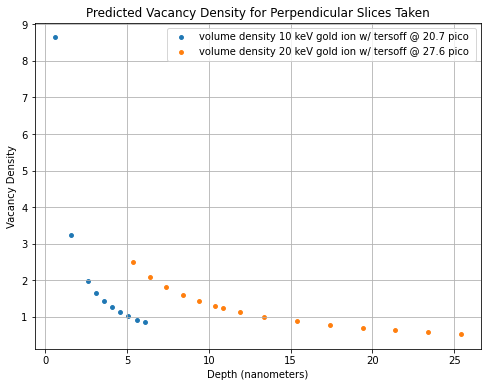

In [95]:
plt.figure(figsize=(8, 6))
x_values3, y_values4 = [x_start3 - x for x in x_end_options], [y_start4 - y for y in y_end_options]

#plt.scatter(x_values1, result1, label = f'gold with thermal @ 60 pico', s = 15)
#plt.scatter(x_values3, result3, label = '10 keV gold ion w/ tersoff @ 20.7 pico', s = 15)
plt.scatter(x_values3, result3, label = 'volume density 10 keV gold ion w/ tersoff @ 20.7 pico ', s = 15)
plt.scatter(y_values4, result4, label = 'volume density 20 keV gold ion w/ tersoff @ 27.6 pico ', s = 15)
plt.title(f'Predicted Vacancy Density for Perpendicular Slices Taken')
plt.xlabel('Depth (nanometers)')
plt.ylabel('Vacancy Density')
plt.legend(loc = 'best')
plt.grid(True)

### Step 7: Try to find track width and length at different depths

In [50]:
''' 
current motivation here - find the closest particles in the entire 360 degree and define that as the boundary
is there someway to exploit the vacancy density done earlier to make this calculation easier?

the plot/information we want is track width (y) vs track depth (x)

recall vacancy definition:

def vacancy_vs_depth(data, start, end): 
    depth = start - end 
    vol = depth * y_len * z_len  
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result
    
recall - the gold ion is being shot along the x-axis headon into the y-axis and z-axis (obviously) on axis = 0 - use to advantage

so from this in theory we can simply start a distance finder for multiple points in a 2pi space from axis = 0 until it reaches a particle

'''

def find_spacing(end, y_ref, z_ref, data, sigma_y=0.1, sigma_z=0.1):
    depth = np.max(data['x'].values) - end  # Get the depth into the sample
    filtered_data = data[np.isclose(data['x'], depth, atol=0.2)]  # Allow slight tolerance for floating-point errors

    if filtered_data.empty:
        print(f"No particles found at x = {depth} (end = {end})")
        return [], [], [], []  # Return empty error lists as well

    degree_spacing = np.linspace(0, 360, 361)  # 0.1-degree increments

    yvalue, zvalue, width_at_x, error_at_x = [], [], [], []
    
    for theta in degree_spacing:
        theta_rad = np.radians(theta)

        dy = np.cos(theta_rad)
        dz = np.sin(theta_rad)

        # Compute radial distances
        distances = np.sqrt((filtered_data['y'] - y_ref)**2 + (filtered_data['z'] - z_ref)**2)
        
        if distances.empty:
            continue  # Skip this angle if no data is found
        
        # Find the minimum distance
        min_idx = np.argmin(distances)
        yvalue.append(filtered_data.iloc[min_idx]['y'])
        zvalue.append(filtered_data.iloc[min_idx]['z'])

        # Compute the error propagation
        distance = distances.iloc[min_idx]
        error_distance = np.sqrt(
            ((filtered_data.iloc[min_idx]['y'] - y_ref) / distance) ** 2 * sigma_y ** 2 +
            ((filtered_data.iloc[min_idx]['z'] - z_ref) / distance) ** 2 * sigma_z ** 2)
        
        error_at_x.append(error_distance)

    if yvalue and zvalue:
        max_distance = np.min(distances)
        width_at_x.append(max_distance)  # Store the min radius
        # Compute a single error value for each `x_end` (e.g., min or mean of errors)
        mean_error = np.mean(error_at_x)  # mean error
    return yvalue, zvalue, width_at_x, mean_error

In [117]:
#test out function validity
x_width_options = [1.0, 2.3, 3.2, 3.9]
x_widths3, x_widths4 = [x_start3 - x for x in x_width_options], [x_start4 - x for x in x_width_options]
sigma_y3, sigma_z3 = np.std(data_3['y'].values), np.std(data_3['z'].values)  # Standard deviation of filtered z-values
sigma_y4, sigma_z4 = np.std(data_4['y'].values), np.std(data_4['z'].values)  # Standard deviation of filtered z-values

for _ in tqdm(range(len(x_width_options))):
    attempty3, attemptz3, attemptdist3, attempterr3 = zip(*[find_spacing(x_end, 0, 0, data_input3, sigma_y3, sigma_z3) for x_end in x_width_options])
    attempty4, attemptz4, attemptdist4, attempterr4 = zip(*[find_spacing(x_end, 0, 0, data_input4, sigma_y4, sigma_z4) for x_end in x_width_options])

100%|██████████| 4/4 [00:04<00:00,  1.06s/it]


/var/folders/8_/7cxg7b591zn267gy4zwgyw6h0000gn/T/ipykernel_77181/3873034553.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='best', fontsize='small')


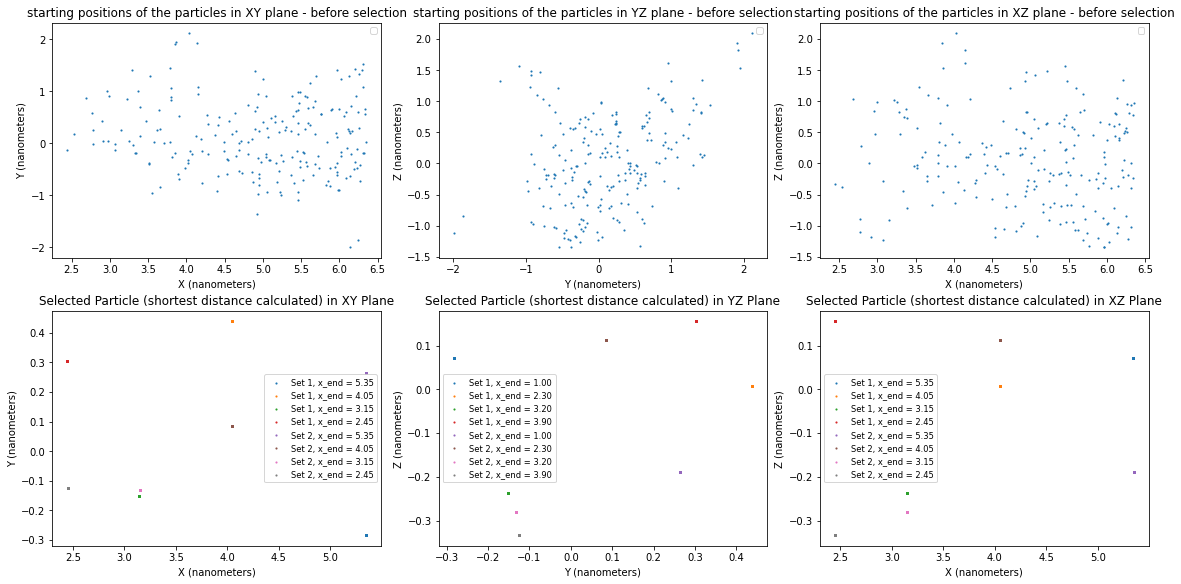

In [118]:
# Create the subplots

fig, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)

# Initial plots
axes[0,0].scatter(data_4['x'].values, data_4['y'].values, s = 5, marker = '.')
axes[0,0].set_title('starting positions of the particles in XY plane - before selection')
axes[0,0].set_xlabel('X (nanometers)')
axes[0,0].set_ylabel('Y (nanometers)')

axes[0,1].scatter(data_4['y'].values, data_4['z'].values, s = 5, marker = '.')
axes[0,1].set_title('starting positions of the particles in YZ plane - before selection')
axes[0,1].set_xlabel('Y (nanometers)')
axes[0,1].set_ylabel('Z (nanometers)')

axes[0,2].scatter(data_4['x'].values, data_4['z'].values, s = 5, marker = '.')
axes[0,2].set_title('starting positions of the particles in XZ plane - before selection')
axes[0,2].set_xlabel('X (nanometers)')
axes[0,2].set_ylabel('Z (nanometers)')

attempty_sets = [attempty3, attempty4]
attemptz_sets = [attemptz3, attemptz4]
attemptdist_sets = [attemptdist3, attemptdist4]
x_end_sets = [x_width_options, x_width_options]
x_start_sets = [x_start3, x_start4]

for set_idx, (atty, attz, attd, x_ends, x_start) in enumerate(zip(attempty_sets, attemptz_sets, attemptdist_sets, x_end_sets, x_start_sets)):
    for i, (y_vals, z_vals, d_vals) in enumerate(zip(atty, attz, attd)):
        # Calculate x_values only for this specific loop
        x_values = x_start - np.array(x_ends)  # Make sure x_values is based on `x_ends`
        
        # Plot XY
        axes[1,0].invert_xaxis()
        axes[1,0].scatter([x_values[i]] * len(y_vals), y_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_values[i]:.2f}")
        
        # Plot YZ
        axes[1,1].scatter(y_vals, z_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_ends[i]:.2f}")
        
        # Plot XZ
        axes[1,2].invert_xaxis()
        axes[1,2].scatter([x_values[i]] * len(z_vals), z_vals, s=5, marker='.',
                          label=f"Set {set_idx+1}, x_end = {x_values[i]:.2f}")


# Set titles and labels
axes[1,0].set_title('Selected Particle (shortest distance calculated) in XY Plane')
axes[1,0].set_xlabel('X (nanometers)')
axes[1,0].set_ylabel('Y (nanometers)')

axes[1,1].set_title('Selected Particle (shortest distance calculated) in YZ Plane')
axes[1,1].set_xlabel('Y (nanometers)')
axes[1,1].set_ylabel('Z (nanometers)')

axes[1,2].set_title('Selected Particle (shortest distance calculated) in XZ Plane')
axes[1,2].set_xlabel('X (nanometers)')
axes[1,2].set_ylabel('Z (nanometers)')

# Add legends
for ax in axes.flat:
    ax.legend(loc='best', fontsize='small')

### Step 8: Recreate the irradiated gold sample plot with error bars to find track width vs depth

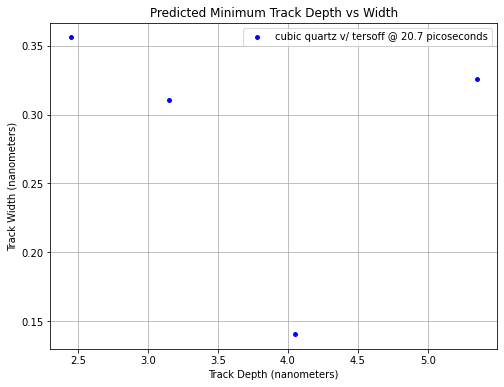

In [119]:
track_depths3 = [abs(x_start3 - x) for x in x_width_options]
track_depths4 = [abs(x_start4 - x) for x in x_width_options]

attemptdist3, attemptdist4 = np.array(attemptdist3).flatten(), np.array(attemptdist4).flatten()
attempterr3, attempterr4 = np.array(attempterr3).flatten(), np.array(attempterr4).flatten()

fig = plt.figure(figsize=(8, 6))
#plt.scatter(x_values1, attemptdist1, label = f'gold within quartz 50 picoseconds', s = 15)
#plt.scatter(x_values2, attemptdist2, label = f'gold outside quartz 80 picoseconds', s = 15)
#plt.scatter(track_depths3, attemptdist3, color = "darkgoldenrod", label = f'cubic quartz w/ vashistha @ 20.7 picoseconds', s = 15)
plt.scatter(track_depths4, attemptdist4, color = "blue", label = f'cubic quartz v/ tersoff @ 20.7 picoseconds', s = 15)
#plt.errorbar(x_widths3, attemptdist3, yerr=attempterr3, fmt='o', color = "darkgoldenrod", markersize=2, label="Vashistha Error")
#plt.errorbar(x_widths4, attemptdist4, yerr=attempterr4, fmt='o', color= "cornflowerblue", markersize=2, label="Tersoff Error")
plt.title(f'Predicted Minimum Track Depth vs Width')
plt.xlabel('Track Depth (nanometers)')
plt.ylabel('Track Width (nanometers)')
plt.legend(loc = 'best')
plt.grid(True)

#see if there is a variable I can output from lammps that tracks the kinetic energy of the gold ion at each time step - should be able to

array([13.21467145, 11.66494773, 13.53619949, 13.61128715])

### Step 9: Subtract the displaced atoms from the original configuration to visualize what the created track would more realistically look like!

In [ ]:
'''

this is a come se dice tomorrow problem

'''

In [ ]:
#can make plot with recoil energy/length vs width from TEM images